# Parametric non-intrusive model order reduction for 1D wildland fire model

Here we describe the application of methods sPOD-NN, sPOD-I and POD-NN on a 1D wildland fire model without any topological changes. The model equations are given in Eq.(30) and Eq.(31) of the paper. The wind velocity is considered to be 0. The results generated in this script are shown in Sec.(3.1.1) in the paper as well.

In [1]:
import sys
sys.path.append('../sPOD/lib/')
sys.path.append('../DL-ROM/LIB/')

In [2]:
from wildfire1D_sup import wildfire1D_sup
import numpy as np

## Basis reconstruction for the 1D wildland fire model

In this part we : 

<ul>
<li>Load the 1D wildland fire data.</li>
<li>Perform sPOD and POD on the generated data.</li>
<li>Extract the time amplitudes according to Eq.(8) and Eq.(13) from the paper.</li>
</ul>

The inputs here include : 
<ul>
<li>$variable$ which is to be set as 0 for "Temperature" and 1 for "Supply mass fraction".</li>
<li>$test\_val$ is the parameter value at which the testing is performed.</li>
</ul>

The sPOD algorithm has to run only once for the basis reconstruction and the results necessary for subsequent steps are stored to save repeated time and effort.

In [3]:
variable = 0
test_val = 558.49

if variable == 0:
    name = "T"
else:
    name = "S"

In [4]:
import os

q = np.load(os.path.abspath(".") + '/wildfire_data/1D/' + 'SnapShotMatrix' + str(test_val) + '.npy')
shifts_test= np.load(os.path.abspath(".") + '/wildfire_data/1D/' + 'Shifts' + str(test_val) + '.npy')

df = wildfire1D_sup(q, shifts_test, param_test_val=test_val, var=variable)

sPOD to be performed only once and the results to be stored

In [5]:
# ############################# Run sPOD on the data ########################## (only once)
# impath = "./wildfire_data/1D/save_Wildfire/" + name + "/"
# import os
# import pickle
# os.makedirs(impath, exist_ok=True)

# Q_frames, U_list, TA_list_training, TA_list_interp, spod_modes = df.run_sPOD(spod_iter=100)  # 100 for T,  50 for S

# with open(impath + 'Q_frames.data', 'wb') as filehandle:
#     pickle.dump(Q_frames, filehandle)
# with open(impath + 'U_list.data', 'wb') as filehandle:
#     pickle.dump(U_list, filehandle)
# with open(impath + 'TA_list_training.data', 'wb') as filehandle:
#     pickle.dump(TA_list_training, filehandle)
# with open(impath + 'TA_list_interp.data', 'wb') as filehandle:
#     pickle.dump(TA_list_interp, filehandle)
# with open(impath + 'spod_modes.data', 'wb') as filehandle:
#     pickle.dump(spod_modes, filehandle)

In [6]:
impath = "./wildfire_data/1D/save_Wildfire/" + name + "/"
import os
import pickle

with open(impath + 'Q_frames.data', 'rb') as filehandle:
    Q_frames = pickle.load(filehandle) 
with open(impath + 'U_list.data', 'rb') as filehandle:
    U_list = pickle.load(filehandle) 
with open(impath + 'TA_list_training.data', 'rb') as filehandle:
    TA_list_training = pickle.load(filehandle) 
with open(impath + 'TA_list_interp.data', 'rb') as filehandle:
    TA_list_interp = pickle.load(filehandle) 
with open(impath + 'spod_modes.data', 'rb') as filehandle:
    spod_modes = pickle.load(filehandle) 
    
TA_TRAIN = np.concatenate(TA_list_training, axis=0)
SHIFTS_TRAIN = [df.shifts_train[0], df.shifts_train[2]]
PARAMS_TRAIN = df.params_train

POD

In [7]:
u, s, vt = np.linalg.svd(np.squeeze(df.q_train), full_matrices=False)

U_POD_TRAIN = u[:, :sum(spod_modes) + df.NumFrames - 1]
TA_POD_TRAIN = np.diag(s[:sum(spod_modes) + df.NumFrames - 1]) @ vt[:sum(spod_modes) + df.NumFrames - 1, :]

Here the testing data is assembled. The sPOD and POD are performed on the testing data and then time amplitudes and shifts are extracted. These are used for final error calculations. The sPOD on the testing data is also performed only once for saving time and effort.

In [8]:
# ###################################### Only for DoF study #######################################
# # No need to be performed again 
# # The results are shown in the paper

# from Helper import *

# frame_wise_sPOD = [8, 4, 8]
# Nmf = spod_modes
# time_amplitudes_1 = TA_TRAIN[:Nmf[0], :]
# time_amplitudes_2 = TA_TRAIN[Nmf[0]:Nmf[0] + Nmf[1], :]
# time_amplitudes_3 = TA_TRAIN[Nmf[0] + Nmf[1]:, :]
# frame_amplitudes_list_training = [
#     time_amplitudes_1[:frame_wise_sPOD[0], :],
#     time_amplitudes_2[:frame_wise_sPOD[1], :],
#     time_amplitudes_3[:frame_wise_sPOD[2], :]
# ]

# TA_TRAIN = np.concatenate(frame_amplitudes_list_training, axis=0)
# U_list = [
#     U_list[0][:, :frame_wise_sPOD[0]], 
#     U_list[1][:, :frame_wise_sPOD[1]],
#     U_list[2][:, :frame_wise_sPOD[2]]
# ]
# spod_modes = frame_wise_sPOD

# frame_amplitudes_list_interp = []
# for frame in range(3):
#     Nmodes = spod_modes[frame]
#     VT = frame_amplitudes_list_training[frame]
#     amplitudes = [np.reshape(VT[n, :], [df.Nsamples_train, len(df.t)]).T for n in range(Nmodes)]
#     frame_amplitudes_list_interp.append(amplitudes)

# TA_list_interp = frame_amplitudes_list_interp
# U_POD_TRAIN = U_POD_TRAIN[:, :sum(spod_modes) + 2]
# TA_POD_TRAIN = TA_POD_TRAIN[:sum(spod_modes) + 2, :]

# ############################################
# data_shape = [len(df.x), 1, 1, df.Nsamples_train*len(df.t)]
# dx = df.x[1] - df.x[0]
# L = [df.x[-1]]

# q_train = [U_list[0] @ frame_amplitudes_list_training[0],
#            U_list[1] @ frame_amplitudes_list_training[1],
#            U_list[2] @ frame_amplitudes_list_training[2]]
# trafos = [ 
# transforms(data_shape, L, shifts=SHIFTS_TRAIN[0], dx=[dx],
#                          use_scipy_transform=False,
#                          interp_order=5),
# transforms(data_shape, L, shifts=np.zeros_like(SHIFTS_TRAIN[0]), trafo_type="identity",
#                          dx=[dx],
#                          use_scipy_transform=False, interp_order=5),
# transforms(data_shape, L, shifts=SHIFTS_TRAIN[1], dx=[dx],
#                          use_scipy_transform=False,
#                          interp_order=5)
# ]

# NumFrames = 3
# q_sPOD = 0
# for frame in range(NumFrames):
#     q_sPOD += trafos[frame].apply(q_train[frame])
# ############################################
# q_POD = U_POD_TRAIN @ TA_POD_TRAIN
# ############################################
# Q_original = df.q_train
# ############################################

# num1 = np.sqrt(np.mean(np.linalg.norm(Q_original - q_sPOD, 2, axis=1) ** 2))
# den1 = np.sqrt(np.mean(np.linalg.norm(Q_original, 2, axis=1) ** 2))

# num2 = np.sqrt(np.mean(np.linalg.norm(Q_original - q_POD, 2, axis=1) ** 2))
# den2 = np.sqrt(np.mean(np.linalg.norm(Q_original, 2, axis=1) ** 2))

# print("Relative reconstruction error indicator for full snapshot(sPOD) is {}".format(num1 / den1))
# print("Relative reconstruction error indicator for full snapshot(POD) is {}".format(num2 / den2))

In [9]:
# ############################# Run sPOD on the test data ########################## (only once)
# import os
# impath = "./wildfire_data/1D/save_Wildfire/" + name + "/" + str(test_val) + "/"
# import pickle
# os.makedirs(impath, exist_ok=True)

# Q_frames_test = df.test_data(spod_iter=100)  # 100 for T  , 50 for S

# with open(impath + 'Q_frames_test.data', 'wb') as filehandle:
#     pickle.dump(Q_frames_test, filehandle)

Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)


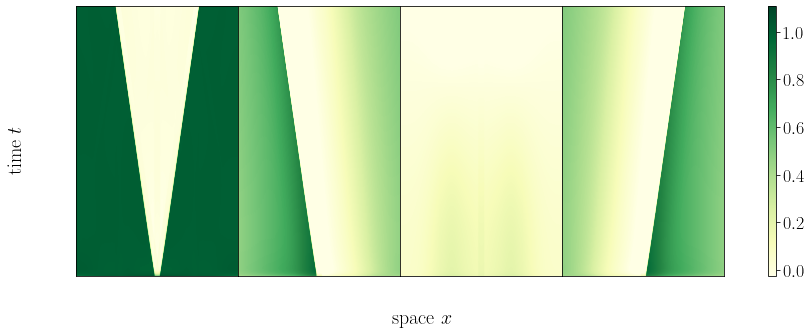

In [10]:
impath = "./wildfire_data/1D/save_Wildfire/" + name + "/" + str(test_val) + "/"
import os
import pickle

with open(impath + 'Q_frames_test.data', 'rb') as filehandle:
    Q_frames_test = pickle.load(filehandle) 
    
# Plot the sPOD decomposed frames for test parameter
df.plot_sPOD_frames(Q_frames_test)

In [11]:
mu_vecs_test = np.asarray([df.param_test_val])
params_test = [np.squeeze(np.asarray([[np.ones_like(df.t) * mu], [df.t]])) for mu in mu_vecs_test]
PARAMS_TEST = np.concatenate(params_test, axis=1)

q1_test = Q_frames_test[0]
q2_test = Q_frames_test[1]
q3_test = Q_frames_test[2]

time_amplitudes_1_test = U_list[0].transpose() @ q1_test
time_amplitudes_2_test = U_list[1].transpose() @ q2_test
time_amplitudes_3_test = U_list[2].transpose() @ q3_test
TA_TEST = np.concatenate((time_amplitudes_1_test, 
                          time_amplitudes_2_test, 
                          time_amplitudes_3_test), axis=0)

SHIFTS_TEST = [df.shifts_test[0], df.shifts_test[2]]

TA_POD_TEST = U_POD_TRAIN.transpose() @ df.q_test

We assemble the $\hat{A}$ matrix according to the Eq.(16) from the paper.

In [12]:
# "0" shift has not been included in the prediction 
shifts_train = np.concatenate((np.reshape(SHIFTS_TRAIN[0], newshape=[1, -1]), np.reshape(SHIFTS_TRAIN[1], newshape=[1, -1])), axis=0)
shifts_test = np.concatenate((np.reshape(SHIFTS_TEST[0], newshape=[1, -1]), np.reshape(SHIFTS_TEST[1], newshape=[1, -1])), axis=0)

ta_train = np.concatenate((TA_TRAIN, shifts_train), axis=0)
ta_test = np.concatenate((TA_TEST, shifts_test), axis=0)

In [13]:
print("Grid, Nx : {}, Nt : {}".format(len(df.x), len(df.t)))
print("Number of sPOD frames : {}".format(len(spod_modes)))
print("Number of modes (frame wise) : {}, {}, {}".format(spod_modes[0], spod_modes[1], spod_modes[2]))
print("Size of training matrix : {} x {}".format(int(ta_train.shape[0]), int(ta_train.shape[1])))

Grid, Nx : 3000, Nt : 600
Number of sPOD frames : 3
Number of modes (frame wise) : 6, 2, 6
Size of training matrix : 16 x 3000


## Neural network training

Based on the data which we obtain from the previous step we train our neural network. For the training we first define certain parameters needed for training step. The parameters are mentioned here are:

<ul>
<li>$scaling$ activates the min-max data scaling for efficient training.</li>
<li>$full\_order\_model\_dimension$ is effectively $M$ which is the total number of grid points.</li>
<li>$reduced\_order\_model\_dimension$ is $n_{\mathrm{dof}}$ mentioned in Eq.(19) in the paper.</li>
<li>$totalModes$ is the total number of modes.</li>
<li>$num\_early\_stop$ defines the early stopping criteria for training step.</li>
</ul>

Subsequently the hyperparameters are:
<ul>
<li>$epochs$ sets the total number of epochs for training.</li>
<li>$lr$ sets the learning rate for training.</li>
<li>$loss\_type$ is the type of loss to consider while training options being $L1$ or $MSE$.</li>
<li>$batch\_size$ sets the total number of minibatches for the training data to be broken down into for effective training.</li>
</ul>

In [14]:
params_sPOD = {
        'scaling': True,
        'full_order_model_dimension': len(df.x),
        'reduced_order_model_dimension': ta_train.shape[0],
        'totalModes': ta_train.shape[0] - len(spod_modes) + 1,
        'num_early_stop': 3000  
    }
params_POD = {
        'scaling': True, 
        'full_order_model_dimension': len(df.x),
        'reduced_order_model_dimension': TA_POD_TRAIN.shape[0],
        'totalModes': TA_POD_TRAIN.shape[0],
        'num_early_stop': 3000
    }

In [15]:
# # training the model
# from DFNN import run_model 
# import time
# tic_sPOD = time.process_time() 
# print("#################################")
# print("sPOD-NN")
# model_sPOD, _, scaling_sPOD = run_model(ta_train, PARAMS_TRAIN, epochs=200000, lr=0.005, loss_type='L1', 
#                                         logs_folder='./DNN_result/wildfire1D/training_results_sPOD/' + name, 
#                                         params=params_sPOD, batch_size=100)
# print("#################################\n")
# toc_sPOD = time.process_time()

# tic_POD = time.process_time()
# print("#################################")
# print("POD-NN")
# model_POD, _, scaling_POD = run_model(TA_POD_TRAIN, PARAMS_TRAIN, epochs=200000, lr=0.005, loss_type='L1', 
#                                       logs_folder='./DNN_result/wildfire1D/training_results_POD/' + name, 
#                                       params=params_POD, batch_size=100)
# print("#################################\n")
# toc_POD = time.process_time()

# print(f"Time consumption in training (sPOD-NN) : {toc_sPOD - tic_sPOD:0.4f} seconds")
# print(f"Time consumption in training (POD-NN) : {toc_POD - tic_POD:0.4f} seconds")

# Neural network prediction

After the training is finished the best weights are saved for network prediction. Here those weights are loaded and the prediction is performed. The dictionary $test$ is defined here which determines whether to run a multi-query scenario or full prediction scenario. If $test['typeOfTest'] = "query"$ then the multi-query scenario is run for which $test['typeOfTest'] = 400$ sets the time step at which the prediction has to be performed. 

Plotting function is only activated for $test['typeOfTest'] = "full"$ which gives us the full prediction throughout all the time steps.

In [16]:
test = {
    'typeOfTest': "full",
    'test_sample': 400
}

In [17]:
import torch
import pathlib
import os
from DFNN import scale_params

# Load the correct model
log_folder_base_sPOD = 'DNN_result/wildfire1D/training_results_sPOD/' + name + '/'
log_folder_trained_model_sPOD = sorted(pathlib.Path(log_folder_base_sPOD).glob('*/'), key=os.path.getmtime)[-1]
PATH_sPOD = str(log_folder_trained_model_sPOD) + '/trained_weights/' + 'weights.pt'

log_folder_base_POD = 'DNN_result/wildfire1D/training_results_POD/' + name + '/'
log_folder_trained_model_POD = sorted(pathlib.Path(log_folder_base_POD).glob('*/'), key=os.path.getmtime)[-1]
PATH_POD = str(log_folder_trained_model_POD) + '/trained_weights/' + 'weights.pt'

# T
# PATH_sPOD = 'DNN_result/wildfire1D/training_results_sPOD/' + name + '/2024_01_27__21-24-34/trained_weights/weights.pt'
# PATH_POD = 'DNN_result/wildfire1D/training_results_POD/' + name + '/2024_01_27__21-43-53/trained_weights/weights.pt'

# S
PATH_sPOD = 'DNN_result/wildfire1D/training_results_sPOD/' + name + '/2025_07_14__13-51-39/trained_weights/weights.pt'
PATH_POD = 'DNN_result/wildfire1D/training_results_POD/' + name + '/2025_07_14__14-04-25/trained_weights/weights.pt'


# Scale the parameters before prediction
if '/trained_weights/weights.pt' in PATH_sPOD: address_sPOD = PATH_sPOD.replace('/trained_weights/weights.pt', '')
scaling_sPOD = np.load(address_sPOD + '/variables/' + 'scaling.npy', allow_pickle=True)

if '/trained_weights/weights.pt' in PATH_POD: address_POD = PATH_POD.replace('/trained_weights/weights.pt', '')
scaling_POD = np.load(address_POD + '/variables/' + 'scaling.npy', allow_pickle=True)

PARAMS_TEST_sPOD = scale_params(PARAMS_TEST, params_sPOD, scaling_sPOD)
PARAMS_TEST_POD = scale_params(PARAMS_TEST, params_POD, scaling_POD)

cpu


In [18]:
if test['typeOfTest'] == "query":
    test_sample = test['test_sample']
    
    ta_test = ta_test[:, test_sample][..., np.newaxis]
    
    TA_TEST = TA_TEST[:, test_sample][..., np.newaxis]
    TA_POD_TEST = TA_POD_TEST[:, test_sample][..., np.newaxis]
    
    tmp = []
    for i in range(df.NumFrames):
        tt = []
        for m in range(spod_modes[i]):
            ampl = TA_list_interp[i][m][test_sample, :][np.newaxis, ...]
            tt.append(ampl)
        tmp.append(tt)
    TA_list_interp = tmp
    
    SHIFTS_TEST[0] = SHIFTS_TEST[0][test_sample]
    SHIFTS_TEST[1] = SHIFTS_TEST[1][test_sample]
    
    PARAMS_TEST_sPOD = PARAMS_TEST_sPOD[:, test_sample][..., np.newaxis]
    PARAMS_TEST_POD = PARAMS_TEST_POD[:, test_sample][..., np.newaxis]

In [19]:
# testing the model
from DFNN import test_model 
import time 

tic = time.process_time()
rel_err_sPOD, results_predicted_sPOD = test_model(ta_test, PARAMS_TEST_sPOD, trained_model=None, saved_model=True, 
                                                  PATH_TO_WEIGHTS=PATH_sPOD, params=params_sPOD, scaling=scaling_sPOD, 
                                                  batch_size=100) 
toc = time.process_time()
print(f"Time consumption in testing sPOD-NN model : {toc - tic:0.4f} seconds")

tic = time.process_time()
rel_err_POD, results_predicted_POD = test_model(TA_POD_TEST, PARAMS_TEST_POD, trained_model=None, saved_model=True, 
                                                PATH_TO_WEIGHTS=PATH_POD, params=params_POD, scaling=scaling_POD, 
                                                batch_size=100)
toc = time.process_time()
print(f"Time consumption in testing POD-NN model : {toc - tic:0.4f} seconds")

Time consumption in testing sPOD-NN model : 0.0095 seconds
Time consumption in testing POD-NN model : 0.0036 seconds


Once the predictions for the time amplitudes and the shifts had been made we now reconstruct the snapshot according to Eq.(11) and Eq.(18) for POD and sPOD based methods respectively

In [20]:
# This cell is reserved for data manipulations for the online analysis
frame_amplitudes_predicted_sPOD = results_predicted_sPOD[:-2, :]
shifts_predicted_sPOD = results_predicted_sPOD[-2:, :]
frame_amplitudes_predicted_POD = results_predicted_POD

#############################################
Online Error checks
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Check 1...
Relative error indicator for shift for frame 1 (sPOD-NN): 0.0007614053851086093
Relative error indicator for shift for frame 3 (sPOD-NN): 0.0008357252000434025
Relative error indicator for shift for frame 1 (sPOD-I): 0.0007827591579172681
Relative error indicator for shift for frame 3 (sPOD-I): 0.0007827591579168779
Check 2...
Relative time amplitude error indicator for frame 1 (sPOD-NN): 0.021759062863306665
Relative time amplitude error indicator for frame 2 (sPOD-NN): 0.08924077095979918
Relative time amplitude error indicator for frame 3 (sPOD-NN): 0.019844078294230176
Relative time amplitude erro

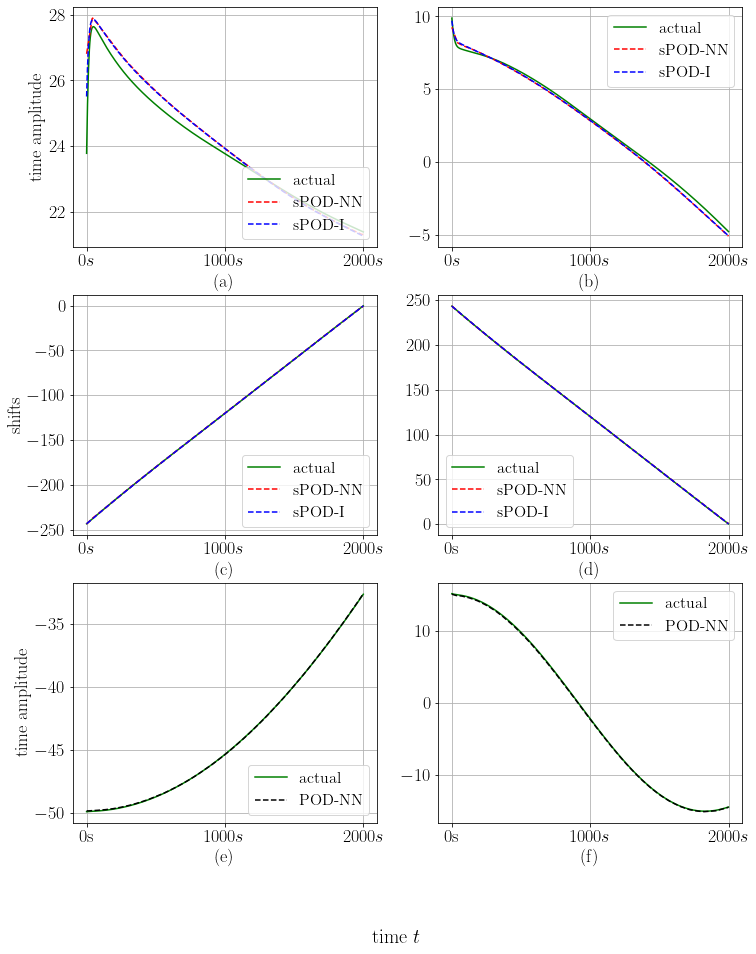

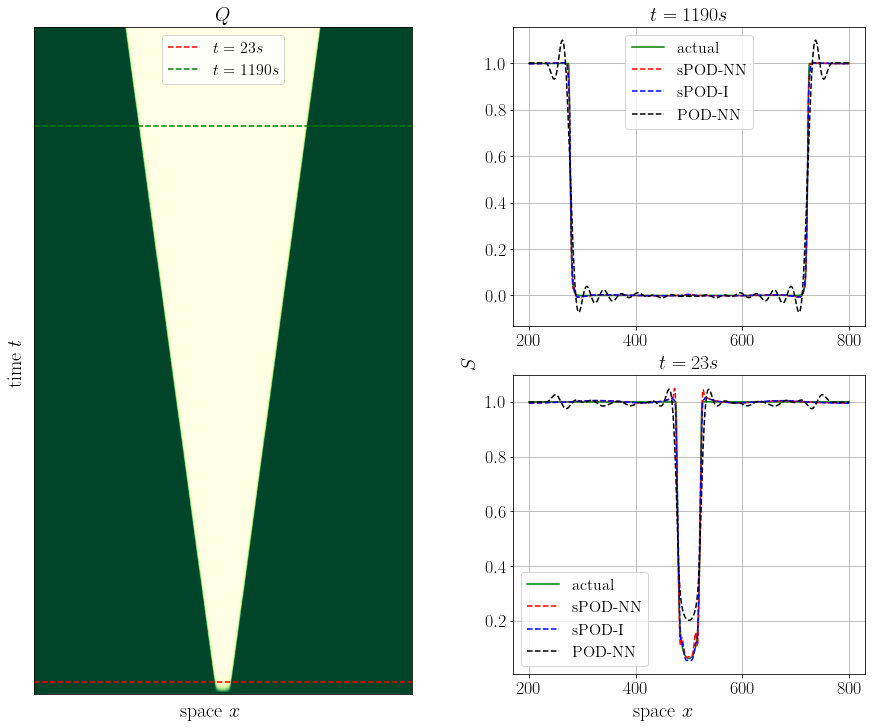

In [21]:
errors, errors_inf = df.plot_online_data(frame_amplitudes_predicted_sPOD, frame_amplitudes_predicted_POD, TA_TEST, 
                             TA_POD_TEST, TA_list_interp, shifts_predicted_sPOD, SHIFTS_TEST, spod_modes, 
                             U_list, U_POD_TRAIN, Q_frames_test, plot_online=True, test_type=test)

## Reconstruction error plots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from Helper import save_fig
from statistics import mean

impath = "../plots/images_wildfire1D/"
os.makedirs(impath, exist_ok=True) 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

SMALL_SIZE = 14   # 16
MEDIUM_SIZE = 18   # 18
BIGGER_SIZE = 20   # 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
truncated_modes = np.array([3 + 2, 5 + 2, 10 + 2, 20 + 2, 24 + 2])
E_sPOD_NN = np.array([0.2395, 0.2321, 0.0793, 0.0653, 0.0372])
E_sPOD_I = np.array([0.2363, 0.2324, 0.0783, 0.0383, 0.0367])
E_POD_NN = np.array([0.5558, 0.4574, 0.3062, 0.1674, 0.1367])

err_1 = errors[0]
err_2 = errors[1]
err_3 = errors[2]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].semilogy(truncated_modes, E_sPOD_NN, color="red", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-NN}}$")
axs[0].semilogy(truncated_modes, E_sPOD_I, color="blue", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-I}}$")
axs[0].semilogy(truncated_modes, E_POD_NN, color="black", linestyle='--', marker="*", label=r"$E^{\mathrm{POD-NN}}$")
axs[0].set_xlabel(r"$n_{\mathrm{dof}}$")
axs[0].set_ylabel('Errors')
axs[0].grid()
axs[0].legend(loc='lower left')

axs[1].semilogy(df.t, err_1, color="teal", linestyle='--', label=r"$E^{\mathrm{sPOD-NN}}_j$")
axs[1].semilogy(df.t, err_2, color="orange", linestyle='--', label=r"$E^{\mathrm{POD-NN}}_j$")
axs[1].semilogy(df.t, err_3, color="dimgrey", linestyle='--', label=r"$E^{\mathrm{sPOD-I}}_j$")
axs[1].set_xlabel(r"time $t$")
axs[1].grid()
axs[1].legend(loc='lower right')


save_fig(filepath=impath + 'Rel_err', figure=fig)
fig.savefig(impath + "Rel_err" + ".pdf", format='pdf',dpi=200, transparent=True, bbox_inches="tight")

In [ ]:
err_1 = errors[0]
err_2 = errors[1]
err_3 = errors[2]

err_1_inf = errors_inf[0]
err_2_inf = errors_inf[1]
err_3_inf = errors_inf[2]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].semilogy(df.t, err_1, color="teal", linestyle='--', label=r"$E^{\mathrm{sPOD-NN}}_j$")
axs[0].semilogy(df.t, err_2, color="orange", linestyle='--', label=r"$E^{\mathrm{POD-NN}}_j$")
axs[0].semilogy(df.t, err_3, color="dimgrey", linestyle='--', label=r"$E^{\mathrm{sPOD-I}}_j$")
axs[0].set_ylabel('Errors')
axs[0].set_xlabel(r"time $t$")
axs[0].grid()
axs[0].legend(loc='lower right')

axs[1].semilogy(df.t, err_1_inf, color="teal", linestyle='--', label=r"$E^{\mathrm{sPOD-NN}}_{j, \infty}$")
axs[1].semilogy(df.t, err_2_inf, color="orange", linestyle='--', label=r"$E^{\mathrm{POD-NN}}_{j, \infty}$")
axs[1].semilogy(df.t, err_3_inf, color="dimgrey", linestyle='--', label=r"$E^{\mathrm{sPOD-I}}_{j, \infty}$")
axs[1].set_xlabel(r"time $t$")
axs[1].grid()
axs[1].legend(loc='lower right')


save_fig(filepath=impath + 'Rel_err', figure=fig)
fig.savefig(impath + "Rel_err" + ".pdf", format='pdf',dpi=200, transparent=True, bbox_inches="tight")